<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/hyperparameter_cnn1d_dna_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter Tuning with Hyperas, Keras, and Sklearn for Deep Learning Genomics

In this notebook, we use keras to assemble a 1D convolutional neural network for a deep learning application in genomics, and tune the network hyperparameters (parameters related to the network architecture and training algorithm) using sklearn.

In prior notebooks, we trained models and came to a better understanding of them using various metrics and plots. In this notebook, we re-use the figures and analysis from prior notebooks to help summarize a larger set of models, without as much of an explanation of how we arrived at those figures or how to interpret them. For more on that, see prior notebooks in the [charlesreid1/deep-learning-genomics](https://github.com/charlesreid1/deep-learning-genomics) repository on Github.

## Import Libraries

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

In [0]:
import os
import math
import numpy as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import joblib

In [0]:
# sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.layers import LeakyReLU
import keras

In [0]:
seed = 1729
numpy.random.seed(seed)

## Define Useful Keras Metrics

Before we get started assembling our model, we define a few useful metric functions to use with the model.

In [0]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


## Load Dataset

In [0]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

Cloning into 'DeepLearningLifeSciences'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 95 (delta 24), reused 85 (delta 17), pack-reused 0
Unpacking objects: 100% (95/95), done.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In contrast to the prior example, which uses the already-provided splits of training, testing, and validation, we will load all of the data all at once into a single X and y pair and use sklearn to split the data into testing and training sets.

In [0]:
def load_all_data():
    
    # load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    
    # load training, validation, and testing sets
    for i,label in enumerate(['train','valid','test']):
        datadir = "%s_dataset"%(label)
        base_filename = "shard-0-%s.joblib"
        X_filename = os.path.join(datadir,base_filename%("X"))
        y_filename = os.path.join(datadir,base_filename%("y"))
        ids_filename = os.path.join(datadir,base_filename%("ids"))
        
        this_X = joblib.load(X_filename)
        this_y = joblib.load(y_filename)
        this_ids = joblib.load(ids_filename)
        this_chromatin = np.array([accessibility[k] for k in this_ids])
        
        # add X and chromatin data
        if i>0:
            X = np.concatenate([X,this_X])
            chromatin = np.concatenate([chromatin,this_chromatin])
            y = np.concatenate([y,this_y])
        else:
            X = this_X
            chromatin = this_chromatin
            y = this_y
        
    return [X,chromatin], y

[X,chromatin], y = load_all_data()

print("Shape of all data:\n")

print("X shape:")
print(np.shape(X))

print("chromatin shape:")
print(np.shape(chromatin))

print("y shape:")
print(np.shape(y))


Shape of all data:

X shape:
(345271, 101, 4)
chromatin shape:
(345271,)
y shape:
(345271, 1)


# Parameter Tuning

In the sections that follow, we assemble a keras 1D CNN and tune parameters of the model.

## Two Approaches to Parameter Tuning

When tuning parameters for a machine learning model, we can adjust parameters and hyperparameters two different ways.

1. **Using sklearn's `GridSearchCV` class.** This is more useful for machine learning models implemented directly with sklearn (i.e., not deep learning models). sklearn implements a class called `GridSearchCV` that takes a set of hyperparameters and associated values to try for each one as an input. It then assembles the Cartesian product (all possible hyperparameter combinations) and, for each hyperparameter combination, performs a k-fold cross-validation of the model. ([Nice GridSearchCV example here](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/).)This gets really expensive really fast, since you assemble and train k models from scratch for every parameter combination. (**Note:** You can wrap a Keras model with a `KerasClassifier` estimator, which allows you to use a `GridSearchCV` with a keras neural network, but this only works if the keras model has [a single input](https://keras.io/scikit-learn-api/). Ours does not.)

2. **Using hyperas/hyperopt with keras.** The [hyperopt](https://github.com/hyperopt/hyperopt) library is a general-purpose Python library for exploring parameter space to find the best parameter combinations to minimize/maximize an objective function. The [hyperas](https://github.com/maxpumperla/hyperas) library is a Python library that adapts hyperopt to be easier to integrate with keras for deep learning models.

## Install Hyperas

hyperas can be installed with pip. First, we have to upgrade `jupyter-console` to avoid [dependency hell](https://github.com/jupyter/jupyter_console/issues/158), then we can install hyperas with pip.

**NOTE:** Remove the `&> /dev/null` to see the output - it's pretty noisy.

In [0]:
!pip install --upgrade --user jupyter-console &> /dev/null

In [0]:
!pip install --user hyperas &> /dev/null

## Parameter Exploration Plan

At this point, we are ready to assemble the model. To use hyperas, we must specify the parameters for hyperas to adjust when we assemble the model. 

For example, if we were assembing an activation layer and wanted to try two different activation functions, we would add a keras layer with a hyperas call:

```python
model.add(Activation({{choice(['relu', 'sigmoid'])}}))
```

So before we start to assemble th model, we should decide what parameters to adjust.

### Parameters that can be adjusted

* The number of stacked convolutional layers (3 in the original version of the problem)
* The number of filters in the convolution layers (16 in the original version of the problem)
* The convolution window size (10 in the original version of the problem)
* The dropout ratio for the dropout layers following the convolutional layers (0.5 originally)
* The sequence length we feed into the neural net (101 originally)
* Activation function used by the convolutional layers (RELU originally)
* Activation function used by final binary classifier output (sigmoid originally)
* Loss function (`binary_crossentropy` originally)
* Optimizer (`adam` originally)

### Parameters that we will adjust

Because models are expensive to train, and we must train one model from scratch for _each_ unique parameter combination, we want to start with parameters that we think will have the largest impact (the parameters the model's correctness is most sensitive to).

We list the three parameters that we will adjust below, with justification:

* **Number of stacked convolutional layers** - more layers means we have a higher potential to extract features at the given layer of resolution, so adding more layers can uncover more structure in the 1D DNA sequences

* **Number of filters in each convolutional layer** - more filters means more parts of the image are covered by more filters, making more likely that features will be extracted; adding more filters can reveal structures across more scales of the sequence; typically convolutional neural networks start with a small number of filters and cascade into more as the network gets deeper, so we explore a network that has increasing numbers of filters in each convolutional layer, and a network that has a fixed number of filters at each convolutional layer.

* **Convolution window size** - a larger convolution window size means we are able to examine more of the sequence _simultaneously_, meaning we are more likely to find non-local effects among features in our sequence

Why not simply crank up all the parameter values? Simpler networks have fewer parameters; as the network complexity increases, the need for data can explode. There is also a risk of overfitting the training data due to having too many parameters, and performing poorly on the general problem, so we want to try both simple and complex models.

### Parameter values

The initial hyperparameter study will search a three-parameter space, trying two values for each parameter. Our goal with this notebook is to demonstrate how to utilize hyperas, so we keep the search simple and limited in scope.

* Number of stacked convolutional layers: \[3, 4\]

* Number of convolutional filters at each layer (single filter size or doubling filter size):
    * 3 convolutional layers: \[16/16/16, 16/32/64\]
    * 4 convolutional layers: \[16/16/16/16, 16/32/64/64\]

* Convolution window size: \[10, 20\]

We are running $2^3 = 8$ cases:

| Case | No. Stacked Conv1D Layers | No. Conv1D Filters | Conv1D Window Size |
|------|---------------------------|--------------------|--------------------|
| 1*  | 3                           | 16/16/16     | 10                |
| 2    | 3                           | 16/16/16     | 25                |
| 3    | 3                           | 16/32/64     | 10                |
| 4    | 3                           | 16/32/64     | 25                |
| 5    | 4                           | 16/16/16/16     | 10                |
| 6    | 4                           | 16/16/16/16     | 20                |
| 7    | 4                           | 16/32/64/64     | 10                |
| 8    | 4                           | 16/32/64/64     | 20                |


In [0]:
import itertools
from pprint import pprint

hyperparam_combos = list(itertools.product([3,4],["16/16/...","16/32/..."],[10,20]))
pprint(hyperparam_combos)

[(3, '16/16/...', 10),
 (3, '16/16/...', 20),
 (3, '16/32/...', 10),
 (3, '16/32/...', 20),
 (4, '16/16/...', 10),
 (4, '16/16/...', 20),
 (4, '16/32/...', 10),
 (4, '16/32/...', 20)]


To create a model that hyperas can call with the different parameter combinations, we will insert special calls to hyperas to tell it which parameter values to insert at different points in the function that creates the keras model. This will allow hyperas to create different models with different parameters or architectures, and to bake complex logic into the variations.

## Create Keras (Hyperas) Model

The next step is to create a function that assembles and returns a keras 1D convolutional network. To use hyperas, we have to write the function as we would normally, but use double-bracket `{{ }}` notation where we want hyperas to substitute hyperparameter values. Inside the brackets are function calls to hyperas functions.

Hyperas has an example in their [github repo readme](https://github.com/maxpumperla/hyperas#complete-example) that shows a complete end-to-end use of hypreas, in addition to an [examples folder](https://github.com/maxpumperla/hyperas/tree/master/examples).

**Boring details:** Under the hood, hyperas is parsing the (syntactically invalid) Python function using [jinja](http://jinja.pocoo.org/), which makes it into a valid Python function that hyperas can put into a temporary file and call during the hyperparameter exploration process.



### Keras and Hyperas Functions

We define two functions to perform the hyperparameter optimization:

* The first function `keras_chromatin_model()` assembles and returns an uncompiled keras neural network with user-specified architecture parameters. This is called $k$ times as part of $k$-fold cross validation, which we perform for each set of input parameters. This function **does not** use any templated hyperas function calls.

* The second function `hyperas_chromatin_model()` is called once by hyperas for each combination of input parameters; it takes all input data to the problem, creates and trains the $k$ neural network models for $k$-fold cross-validation, and returns the aggregate metric (and model(s)?) to hyperas. This function **does** use templated hyperas function calls.

In [0]:
def keras_chromatin_model(n_convolutional_layers, n_convolutional_filters, convolution_window):
    """
    This function takes network architecture parameters as inputs,
    and returns an uncompiled keras 1D convolutional neural network
    with the specified architecture.
    """
    # ----------------------------
    # Sequence branch of network
    # (1D DNA sequence)
    
    # Input
    seq_in = Input(shape=(seq_length,n_features))
    
    # Fencepost pattern
    seq = seq_in
    
    for i in range(n_convolutional_layers):
        seq = Conv1D(n_convolutional_filters[i], 
                     convolution_window,
                     activation='relu', 
                     padding='same',
                     kernel_initializer='normal')(seq)
        seq = Dropout(0.5)(seq)
    
    # Flatten to 1D
    seq = Flatten()(seq)
    
    # Assemble the sequential branch of network
    seq = keras.Model(inputs=seq_in, outputs=seq)
    
    # ---------------------------
    # Chromatin branch of network
    
    # Input
    chrom_input = Input(shape=(1,))

    # ---------------------------
    # Combine networks
    fin = keras.layers.concatenate([seq.output, chrom_input])
    fin = Dense(1,
                activation='sigmoid', 
                kernel_initializer='normal')(fin)
    chrom_model = keras.Model(inputs=[seq.input,chrom_input], 
                              outputs=fin)

    return chrom_model

In [0]:
def hyperas_chromatin_model(datagen, X, y):
    """
    This function takes all of the input data for the problem as input,
    creates a keras 1D convolutional neural network, trains it on the
    given input data, and returns a dictionary with results that hyperas
    can use.
    
    This function illustrates the use of cross-validation when training 
    the model and computing the final metric returned to hyperas 
    (the one that hyperas will use to pick the "best" model).
    To skip cross-validation, you just need to modify the contents
    of the function below.
    
    Inputs:
    - datagen is the data generating function
    - X is all input data
    - y is all output labels
    
    Outputs:
    - a dictionary with three keys:
    - "loss" the loss function to use
    - "status" the return status of the process
    - "model" the model itself
    """
    #############################################
    # Problem-specific parameters
    
    # length of k-mer over which we're convoluting
    seq_length = 101
    
    # length of DNA alphabet
    n_features = 4
    
    # cross-validation settings
    n_fold = 2
    
    # colors to associate with each fold
    colors = ['dusty purple','dusty green']
    fold_colors = [sns.xkcd_rgb[j] for j in colors]
    
    # network settings
    n_epochs = 5
    
    
    #############################################
    # Hyperparameters set by hyperas
    
    n_convolutional_layers = {{choice([3,4])}}
    convolutional_filters_mode = {{choice[16,32]}}
    convolution_window = {{choice[10,20]}}
    
    unique_param_string = "layers%d_filtermode%d_window%d"%(
            n_convolutional_layers,
            convolutional_filters_mode,
            convolution_window
    )
    
    
    #############################################
    # Construct network
    
    # if mode = 16, use all 16s for every layer
    # if mode = 32, double each layer until 64
    n_convolutional_filters = None
    if convolutional_filters_mode==16:
        if n_convolutional_layers==3:
            n_convolutional_filters = [16,16,16]
        elif n_convolutional_layers==4:
            n_convolutional_filters = [16,16,16,16]
            
    elif convolutional_filters_mode==32:
        if n_convolutional_layers==3:
            n_convolutional_filters = [16,32,64]
        elif n_convolutional_filters==4:
            n_convolutional_filters = [16,32,64,64]

    if n_convolutional_filters==None:
        msg = "Error: invalid number of filters per layer or number of layers, could not set number of filters for layers."
        raise Exception(msg)

    chrom_model = keras_chromatin_model(n_convolutional_layerrs, n_convolutional_filters, convolution_window)
    
    
    #############################################
    # Input data

    # stratified = ratios of classes are preserved in each fold
    shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                     train_size = 0.75,
                                     test_size = 0.25,
                                     random_state = seed)
    
    # ------------
    # Begin cross-validation process
    #
    # Iterate over each of the k-fold training/testing splits
    # and create and train a model from scratch. Save the
    # training history, then return the model and its history.

    models = []
    histories = []
    for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
        
        # ---------------------------
        # Assemble class weights 
        # from the training data only
        # (no peeking at the test data!)
        classes = np.unique(y_train)
        labels = np.squeeze(y_train)
        weights = class_weight.compute_class_weight('balanced',classes,labels)
        class_weights = {}
        for c,w in zip(classes,weights):
            class_weights[c] = w
        
        
        #############################################
        # Model training
        
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]

        # Compile the model
        chrom_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       class_weight=class_weights,
                       metrics=['accuracy',
                               precision,
                               recall,
                               fvalue])

        # Fit to data
        hist = chrom_model.fit([X_train,chrom_train], y_train,
                               batch_size = 1000,
                               epochs = n_epochs,
                               class_weight = class_weights,
                               verbose = 0,
                               validation_data = ([X_test,chrom_test], y_test))
        
        models.append(chrom_model)
        histories.append(hist)
    
    #############################################
    # Post-process metrics
    
    '''
    We have multiple metrics for each model:
    - accuracy
    - precision
    - recall
    - f1 score
    - all of above at each epoch
    
    Once we use each model to evaluate y_test, we can get:
    - confusion matrix
    - construct roc with confidence interval
    - roc_auc_score
    
    We can aggregate these metrics many ways, 
    but for now we stick to using roc_auc_score.
    hyperas will use that to pick the best model.
    
    We should make the plots and save them to 
    image files, then display the image files in
    notebook cells below when we analyze the results
    of the hyperparamter study.
    '''
    # ---------------------
    # Compute aggregate statistics
    # for each metric
    
    loss      = [h.history['val_loss'] for h in histories]
    loss_mean = np.mean(loss)
    loss_std  = np.std(loss)
    
    acc       = [h.history['val_acc'] for h in histories]
    acc_mean  = np.mean(acc)
    acc_std   = np.std(acc)
    
    prec      = [h.history['val_pprecision'] for h in histories]
    prec_mean = np.mean(prec)
    prec_std  = np.std(prec)
    
    rec       = [h.history['val_recall'] for h in histories]
    rec_mean  = np.mean(rec)
    rec_std   = np.std(rec)
    
    
    
    # ---------------------
    # Define functions to plot metric histories
    
    def loss_rate_plot(histories, ax, label='', legend=False):
        
        for ih, hist in enumerate(histories):
            
            ax.plot(hist.history['loss'], 
                    label='Train Loss (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='--')

            ax.plot(hist.history['val_loss'], 
                    label='Test Loss (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='-')

        if label=='':
            ax.set_title("Loss", size=14)
        else:
            ax.set_title("Loss (%s)"%(label), size=14)
            
        ax.set_ylabel('Loss')
        ax.set_xlabel('Training epoch')
        
        if legend:
            ax.legend(loc='upper right')
    
    def accuracy_rate_plot(histories, ax, label='', legend=False):
        
        for ih, hist in enumerate(histories):
            
            ax.plot([j*100 for j in hist.history['acc']],
                    label='Train Acc (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='--')
                    
            ax.plot([j*100 for j in hist.history['val_acc']],
                    label='Test Acc (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='-')
        
        if label=='':
            ax.set_title("Accuracy", size=14)
        else:
            ax.set_title("Accuracy (%s)"%(label), size=14)
            
        ax.set_ylabel('Accuracy %')
        ax.set_xlabel('Training epoch')
        
        if legend:
            ax.legend(loc='lower right')

    def precision_rate_plot(histories, ax, label='', legend=False):
        
        for ih, hist in enumerate(histories):
            
            ax.plot([j*100 for j in hist.history['precision']],
                    label='Train Recall (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='--')
            
            ax.plot([j*100 for j in hist.history['val_precision']],
                    label='Test Recall (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='-')
            
        if label=='':
            ax.set_title("Precision", size=14)
        else:
            ax.set_title("Precision (%s)"%(label), size=14)
            
        ax.set_ylabel('Precision %')
        ax.set_xlabel('Training epoch')
        
        if legend:
            ax.legend(loc='lower right')

    def recall_rate_plot(histories, ax, label='', legend=False):
        
        for ih, hist in enumerate(histories):
            
            ax.plot([j*100 for j in hist.history['recall']],
                    label='Train Recall (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='--')

            ax.plot([j*100 for j in hist.history['val_recall']],
                    label='Test Recall (%d)'%(ih+1),
                    color=fold_colors[ih],
                    linestyle='--')

        if label=='':
            ax.set_title("Recall", size=14)
        else:
            ax.set_title("Recall (%s)"%(label), size=14)
            
        ax.set_ylabel('Recall %')
        ax.set_xlabel('Training epoch')
        
        if legend:
            ax.legend(loc='lower right')
    
                    
    # ---------------------
    # Define functions to make confusion matrix plot
    
    def plot_confusion_matrix(ax, y_true, y_pred, classes,
                              title=None,
                              cmap=plt.cm.Blues):
        
        if title is None:
            title = "Confusion Matrix"

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Plot confusion matrix
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), 
                 rotation=45,
                 ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else ','
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", 
                        va="center",
                        color="white" if cm[i, j] > thresh else "black")
                    
    # ---------------------
    # Define functions to plot ROC curves
    
    def plot_roc_confidence(models, ax, X, chromatin, y, shuffle):
        """Plot the ROC curve with confidence interval on ax.
        Return the mean and std of the ROC AUC, computed over
        each of the k folds from cross-validation.
        """
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1,100)

        for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

            print("Working on fold %d..."%(ifold+1))

            X_train, X_test = X[train_ix], X[test_ix]
            y_train, y_test = y[train_ix], y[test_ix]
            chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]

            model = models[ifold]

            y_test_pred = model.predict([X_test,chrom_test]).ravel()

            fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
            
            tprs.append(interp(mean_fpr,fpr,tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr,tpr)
            aucs.append(roc_auc)
            
            # Draw every ROC curve, lightly
            ax.plot(fpr,tpr, alpha=0.3)
            
    mean_tpr = np.mean(tprs,axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Draw the mean curve
    ax.plot(mean_fpr, mean_tpr, 
            color='b', alpha=0.8)

    # Now fill in the area between +/- std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, 
                    color='grey', alpha=0.2)
    
    # Diag for ref
    ax.plot([0,1],[0,1],'--k',lw=2)

    ax.set_title('ROC Curve, 1D CNN With Chromatin')
    
    return mean_auc, std_auc

                    
    ####################################
    # Make plots

    # ---------------------
    # Plot metric histories for all the folds
    # and save the plot to a file
    
    # 4 subplots for 4 metrics
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))
    
    loss_rate_plot(fithists[i], ax1, legend=True)
    accuracy_rate_plot(fithists[i], ax2, legend=True)
    precision_rate_plot(fithists[i], ax3, legend=True)
    recall_rate_plot(fithists[i], ax4, legend=True)
    
    metric_histories_img = 'MetricHistories_%s.png'%(unique_param_string)
    print("Saving metric histories to %s"%(metric_histories_img))
    fig.savefig(metric_histories_img)


    # ---------------------
    # Plot confusion matrix 
    # for all the folds for this model.
    # Save plots to files.
    
    cm_fig, cm_axes = plt.subplots(nrows=len(histories),ncols=1)
    roc_fig, roc_axes = plt.subplots()
    
    for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
        hist = histories[ifold]
        model = models[ifold]
        
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
        
        y_test_pred = model.predict([X_test,chrom_test])
        y_test_pred = np.round(y_test_pred)
        
        # Confusion matrix plot
        cm_title = "Confusion Matrix (Fold %d)"%(ifold+1)
        cm_ax = cm_axes[ifold]        
        plot_confusion_matrix(cm_ax,y_test,y_test_pred,title=cm_title)
    
    cm_img = 'ConfusionMatrix_%s.png'%(unique_param_string)
    print("Saving confusion matrices to %s"%(cm_img))
    cm_fig.savefig(cm_img)
    
    # ---------------------
    # Plot ROC curve (and get ROC AUC)
    # for all the folds for this model.
    # Save plots to files.
    
    roc_fig, roc_ax = plt.subplots(1,1, figsize=(8,6))
    
    mean_auc, std_auc = plot_roc_confidence(models, roc_ax, X, chromatin, y, shuffle)
    
    roc_img = 'ROCConfidence_%s.png'%(unique_param_string)
    print('Saving ROC confidence curve to %s'%(roc_img))
    roc_fig.savefig(roc_img)
    
    print("Area under ROC curve:")
    print("\tMean: %0.4f"%(mean_auc))
    print("\tStd: %0.4f"%(std_auc))

    # which model are we supposed to return?
    # can we return a list? 
    # can we create an aggregate model that wraps all 3? 
    
    return {'loss': mean_auc, 'status': STATUS_OK, 'model': models}


This is currently our stopping point.


...



...



...


...

## Performing Cross Validation Manually

To perform cross validation and incorporate sample weights for imbalanced classes (many more negative examples than positive examples), we can't use weights with sklearn directly, so we do cross-validation manually.

The [StratifiedKFold](https://sklearn.org/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) object can give us a set of k testing/training sets by using the `split()` method, which returns an iterator with the training/testing indices. This allows us to assemble all inputs (X and y, weights, labels, chromatin accessibility, etc.).

The [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) object also provides a split method.

In [0]:
n_epochs = 100
n_fold = 3
include_chromatin_data = True

# we can use either of these,
# but we'll opt for shuffle

kfold = StratifiedKFold(n_splits=n_fold, 
                        shuffle=True, 
                        random_state=seed)

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

models = []
fithists = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    print("Training on fold %d..."%(ifold+1))
    
    
    # if we use the chromatin model, we need a list of inputs
    
    if include_chromatin_data:
        model = create_chromatin()
        hist = model.fit([X_train,chrom_train], y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=([X_test,chrom_test],y_test,w_test))
    else:
        model = create_baseline()
        hist = model.fit(X_train, y_train,
                         sample_weight = w_train,
                         batch_size = 1000,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=(X_test,y_test,w_test))

    models.append(model)
    fithists.append(hist)
    
    print("Done")
    

Training on fold 1:
Done
Training on fold 2:
Done
Training on fold 3:
Done


In [0]:
print("Model results (validation):")
print("\n")
print("Loss (Mean):      %0.4f"%(np.mean([h.history['val_loss'] for h in fithists])))
print("Loss (Std):       %0.4f"%(np.std([h.history['val_loss'] for h in fithists])))
print("\n")
print("Accuracy (Mean):  %0.2f%%"%(100*np.mean([h.history['val_acc'] for h in fithists])))
print("Accuracy (Std):   %0.2f%%"%(100*np.std([h.history['val_acc'] for h in fithists])))
print("\n")
print("Precision (Mean): %0.2f%%"%(100*np.mean([h.history['val_precision'] for h in fithists])))
print("Precision (Std):  %0.2f%%"%(100*np.std([h.history['val_precision'] for h in fithists])))
print("\n")
print("Recall (Mean):    %0.2f%%"%(100*np.mean([h.history['val_recall'] for h in fithists])))
print("Recall (Std):     %0.2f%%"%(100*np.std([h.history['val_recall'] for h in fithists])))

Model results (validation):


Loss (Mean):      0.6158
Loss (Std):       0.0452


Accuracy (Mean):  77.22%
Accuracy (Std):   23.06%


Precision (Mean): 1.71%
Precision (Std):  0.91%


Recall (Mean):    53.38%
Recall (Std):     14.93%


In [0]:
def loss_rate_plot(hist, ax, label='',legend=False):
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    if label=='':
        ax.set_title("Loss Rate", size=14)
    else:
        ax.set_title("Loss Rate (%s)"%(label), size=14)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training interations')
    if legend:
        ax.legend(['Training', 'Validation'], loc='upper right')

def accuracy_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['acc']])
    ax.plot([j*100 for j in hist.history['val_acc']])
    if label=='':
        ax.set_title("Accuracy", size=14)
    else:
        ax.set_title("Accuracy (%s)"%(label), size=14)
    ax.set_ylabel('Accuracy %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def precision_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['precision']])
    ax.plot([j*100 for j in hist.history['val_precision']])
    if label=='':
        ax.set_title("Precision", size=14)
    else:
        ax.set_title("Precision (%s)"%(label), size=14)
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def recall_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['recall']])
    ax.plot([j*100 for j in hist.history['val_recall']])
    if label=='':
        ax.set_title("Recall", size=14)
    else:
        ax.set_title("Recall (%s)"%(label), size=14)
    ax.set_ylabel('Recall %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

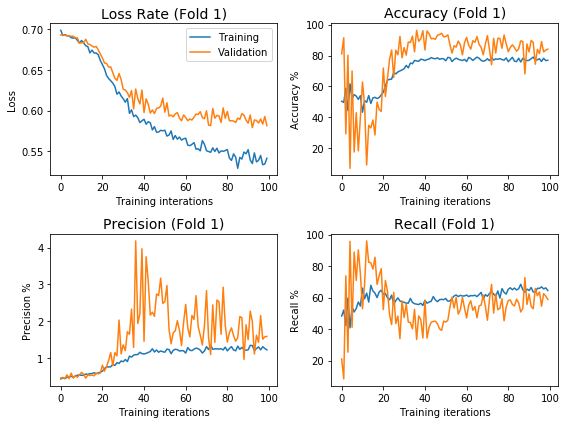

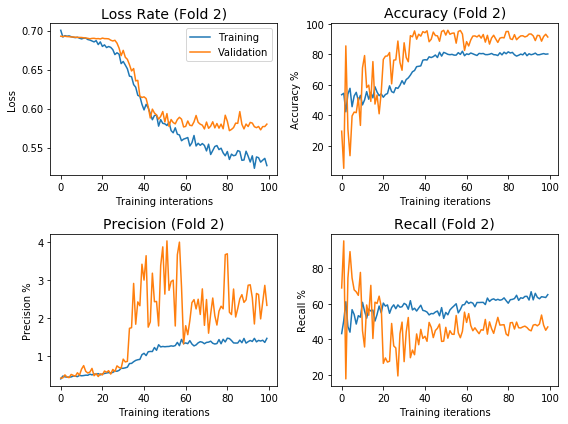

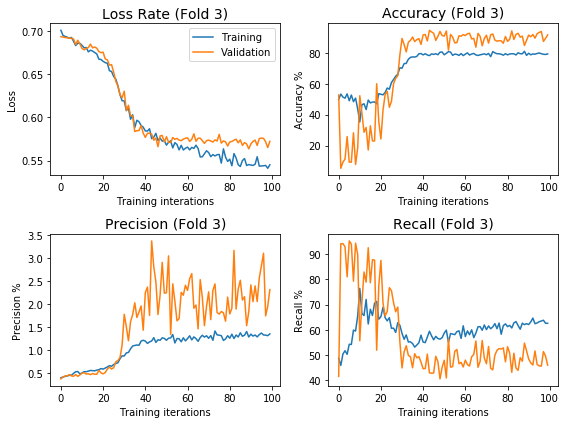

In [0]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists[i], ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists[i], ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists[i], ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else ','
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

---------------
Fold 1:
Confusion matrix, without normalization
[[86917 16227]
 [  178   260]]
---------------
Fold 2:
Confusion matrix, without normalization
[[94359  8785]
 [  229   209]]
---------------
Fold 3:
Confusion matrix, without normalization
[[94641  8503]
 [  234   204]]


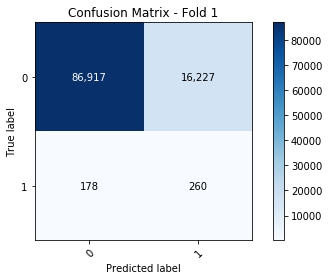

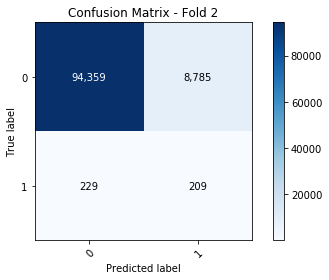

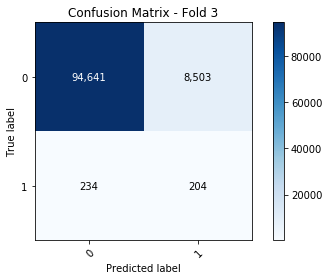

In [0]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test])
    else:
        y_test_pred = model.predict(X_test)
        
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d"%(ifold+1))


In [0]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [0]:
def plot_roc_curve(y_true, y_pred, weights):
    fpr, tpr, _ = roc_curve(y_true, y_pred)#, 
                            #sample_weight = weights)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_pred))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0,1],[0,1],'k--')
    ax.set_title("ROC Curve")
    plt.legend(loc='lower right')
    plt.show()
    
    fig.tight_layout()
    return ax

Finally, we compute the ROC curve for all k models from the k-fold cross-validation and use those curves to assemble the mean and variance of the ROC curve at every point. See [ROC with cross validation example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) in the sklearn documentation.

Working on fold 1...
Working on fold 2...
Working on fold 3...
Area under curve:
Mean: 0.7692
Std: 0.0061


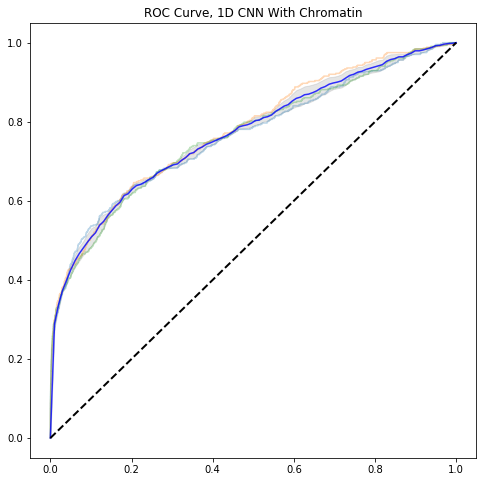

In [0]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    w_train, w_test = np.squeeze(w[train_ix]), np.squeeze(w[test_ix])
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test]).ravel()
    else:
        y_test_pred = model.predict(X_test).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)


mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()

## Class Weights

Next we try replacing the weights that came with the data set with class weights. Let's review the imbalance in our data:

In [0]:
neg = np.sum(y==0)
pos = np.sum(y==1)
print("Negative examples: %d"%(neg))
print("Positive examples: %d"%(pos))
print("Percent positive: %0.2f%%"%(100*(pos/(pos+neg))))

Negative examples: 343811
Positive examples: 1460
Percent positive: 0.42%


We can use the `class_weight` module from sklearn to automatically compute class weights, which can be passed to keras when we fit our model to data.

In [0]:
from sklearn.utils import class_weight

classes = np.unique(y_train)
labels = np.squeeze(y_train)

weights = class_weight.compute_class_weight('balanced',classes,labels)

class_weights = {}
for c,w in zip(classes,weights):
    class_weights[c] = w
print(class_weights)

{0: 0.5021232657572496, 1: 118.2431506849315}


Now we re-fit the model to data, this time using the class weights from sklearn instead of the weights provided in the data files:

In [0]:
n_epochs = 100
n_fold = 3
include_chromatin_data = True

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

models2 = []
fithists2 = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    print("Training on fold %d..."%(ifold+1))
    
    model = create_chromatin()
    hist = model.fit([X_train,chrom_train], y_train,
                     class_weight = class_weights,
                     batch_size = 1000,
                     epochs = n_epochs,
                     verbose = 0,
                     validation_data=([X_test,chrom_test],y_test))
    
    models2.append(model)
    fithists2.append(hist)
    
    print("Done")

Training on fold 1...
Done
Training on fold 2...
Done
Training on fold 3...
Done


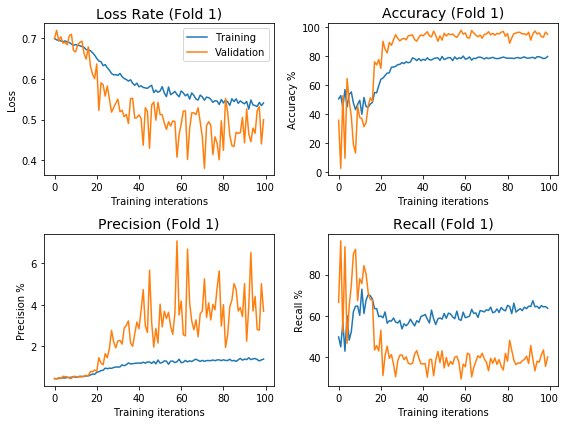

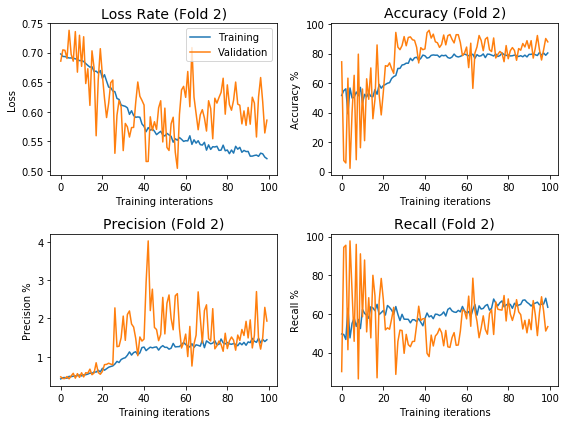

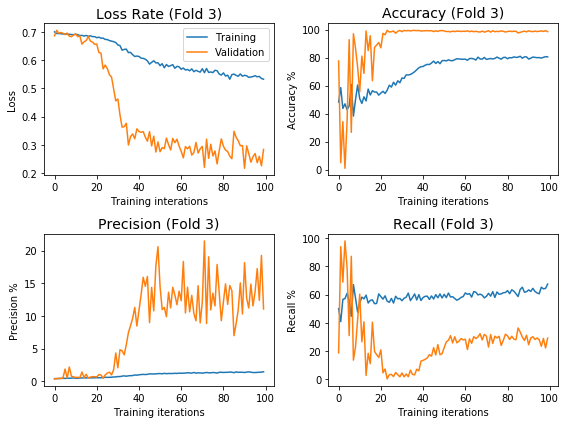

In [0]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists2[i], ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists2[i], ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists2[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists2[i], ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

---------------
Fold 1:
Confusion matrix, without normalization
[[98524  4620]
 [  261   177]]
---------------
Fold 2:
Confusion matrix, without normalization
[[90942 12202]
 [  199   239]]
---------------
Fold 3:
Confusion matrix, without normalization
[[101989   1155]
 [   301    137]]


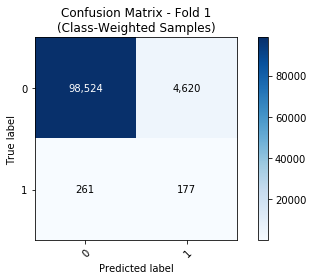

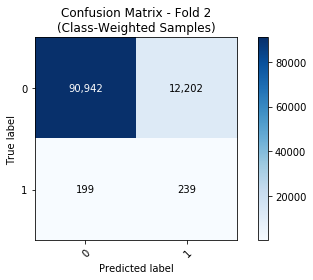

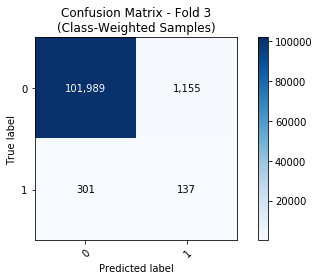

In [0]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models2[ifold]
    
    y_test_pred = model.predict([X_test,chrom_test])
    
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d\n(Class-Weighted Samples)"%(ifold+1))


The code below is similar to, but slightly modified from, the ROC plot above. It shows the same quantity: the ROC curves for all k models from the k-fold cross-validation, and the mean and standard deviation assembled from those models.

Working on fold 1...
Working on fold 2...
Working on fold 3...
Area under curve:
Mean: 0.7737
Std: 0.0060


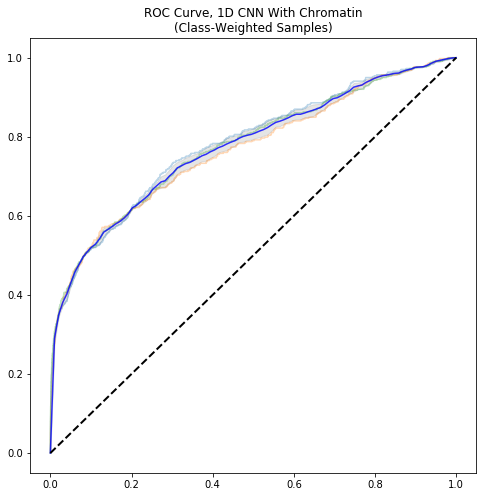

In [0]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models2[ifold]
    
    y_test_pred = model.predict([X_test,chrom_test]).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)

    
mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin\n(Class-Weighted Samples)')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()